In [ ]:

!pip install category_encoders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from category_encoders import TargetEncoder
from datetime import datetime
from google.colab import drive

from sklearn.compose import make_column_transformer
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, StratifiedShuffleSplit, train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.tree import DecisionTreeRegressor

from tensorflow.keras.layers import Dense, Dropout

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data = pd.read_csv("/content/drive/MyDrive/listings_cols_removed.csv")
data

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (42) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,name,description,neighborhood_overview,host_id,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,Clean & quiet apt home by the park,Renovated apt home in elevator building.<br />...,Close to Prospect Park and Historic Ditmas Park,2787,John,9/7/08,"New York, NY",Educated professional living in Brooklyn. I l...,within an hour,100%,...,5.00,4.75,4.88,NaN,f,9,1,6,2,0.11
1,Skylit Midtown Castle,"Beautiful, spacious skylit studio in the heart...",Centrally located in the heart of Manhattan ju...,2845,Jennifer,9/9/08,"New York, NY",A New Yorker since (Phone number hidden by Air...,within a day,75%,...,4.80,4.81,4.40,NaN,f,3,3,0,0,0.31
2,BlissArtsSpace!,One room available for rent in a 2 bedroom apt...,NaN,7356,Garon,2/3/09,"New York, NY","I am an artist(painter, filmmaker) and curato...",within an hour,100%,...,4.91,4.47,4.52,NaN,f,2,0,2,0,0.31
3,Beautiful Queens Brownstone! - 5BR,"<b>The space</b><br />Beautiful, fully furnish...",NaN,204539,Mark,8/17/10,"New York, NY",Father of two boys - 9 & 10.,within an hour,100%,...,5.00,4.82,4.55,NaN,f,6,6,0,0,0.10
4,"Spacious Brooklyn Duplex, Patio + Garden",We welcome you to stay in our lovely 2 br dupl...,NaN,7378,Rebecca,2/3/09,"New York, NY","Rebecca is an artist/designer, and Henoch is i...",NaN,NaN,...,5.00,4.67,5.00,NaN,f,1,1,0,0,0.03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39876,Private Modern House by The Beach,Private modern house by the Beach with all com...,Rockaway Beach is a neighborhood that gives it...,23049030,Ramón,10/27/14,"New York, NY",NaN,within an hour,100%,...,5.00,4.94,4.88,NaN,f,1,1,0,0,1.22
39877,Beautiful apartment - minutes to NYC,Our apartment is straight across the river fro...,Our apartment is located in a very interesting...,48009648,Nathan,11/2/15,"New York, NY",NaN,within an hour,100%,...,4.96,4.81,4.85,NaN,f,1,1,0,0,2.12
39878,"1 Bedroom Basement, NEWLY Renovated",With easy access to multiple bus stops and the...,NaN,371552251,Sheraz,10/11/20,"Floral Park, NY",NaN,within an hour,100%,...,4.36,4.36,4.55,NaN,t,1,1,0,0,0.50
39879,"Luxurious private waterfront terrace, 2BR 2BA Apt","This two bed, two bath apartment overlooking t...",NaN,151487807,Asser,9/21/17,"New York, NY",Management Consultant living in NYC,NaN,NaN,...,NaN,NaN,NaN,NaN,f,1,1,0,0,NaN


# data cleaning

In [ ]:
data.isnull().sum()

name                                               13
description                                       845
neighborhood_overview                           16415
host_id                                             0
host_name                                          50
host_since                                         50
host_location                                    6883
host_about                                      17372
host_response_time                              13548
host_response_rate                              13548
host_acceptance_rate                            11861
host_is_superhost                                  29
host_listings_count                                50
host_total_listings_count                          50
host_verifications                                  0
host_has_profile_pic                               50
host_identity_verified                             50
neighbourhood_cleansed                              0
neighbourhood_group_cleansed

In [ ]:
# Drop columns
unused_cols = ["host_id", "host_name", "host_listings_count", "host_total_listings_count", "review_scores_rating",
               "bathrooms", "bedrooms", "beds", "minimum_nights_avg_ntm", "maximum_nights_avg_ntm",
               "number_of_reviews_ltm", "license", "name", "description", "neighborhood_overview", "host_about",
               "amenities", "property_type"]
data.drop(columns = unused_cols, inplace = True)

In [ ]:
# Filter rows (after parsing `price`) and drop necessary NaN's
data['price'] = data['price'].replace('[\$,]', '', regex = True).astype(float)
data = data[data.price <= 1500]
data = data[data.price > 10]
data = data[data.accommodates > 0]
data.dropna(subset = ["bathrooms_text"], inplace = True)

In [ ]:
# Parse boolean columns
data.host_has_profile_pic = data.host_has_profile_pic == "t"
data.host_identity_verified = data.host_identity_verified == "t"
data.host_is_superhost = data.host_is_superhost == "t"
data.instant_bookable = data.instant_bookable == "t"
data["host_loc_nyc"] = data.host_location == "New York, NY"

In [ ]:
# Encode `host_response_rate`
oe = OrdinalEncoder(
    categories = [["within an hour", "within a few hours", "within a day", "a few days or more"]],
    handle_unknown = "use_encoded_value", unknown_value = 4
)
data["host_response_time"] = oe.fit_transform(data.loc[:, ["host_response_time"]])

In [ ]:
# Parse float columns
data["host_response_rate"] = data["host_response_rate"].str.replace("%", "").astype(float) / 100
data["host_acceptance_rate"] = data["host_acceptance_rate"].str.replace("%", "").astype(float) / 100

In [ ]:
# The `bathrooms_text` of half-baths does not start with numbers
print(data.bathrooms_text[~data["bathrooms_text"].str.contains("^\d")])

73        Shared half-bath
145              Half-bath
172              Half-bath
297      Private half-bath
343       Shared half-bath
               ...        
38278            Half-bath
38790     Shared half-bath
39040     Shared half-bath
39239            Half-bath
39269            Half-bath
Name: bathrooms_text, Length: 72, dtype: object


In [ ]:
# We extract floating point numbers first and fill NaN's with 0.5 later
data["bath_num"] = data["bathrooms_text"].str.extract("^(\d+(\.\d)?)")[0].astype(float)
data["bath_private"] = ~data["bathrooms_text"].str.contains("shared", case = False)

In [ ]:
# Fill NaN values
na_fill_vals = {
    "host_response_rate": data["host_response_rate"].mean(),
    "host_acceptance_rate": data["host_acceptance_rate"].mean(),
    "reviews_per_month": 0,
    "bath_num": 0.5
}

for col_name in data.columns:
    if col_name.startswith("review_scores_"):
        na_fill_vals[col_name] = data[col_name].mean()

print(na_fill_vals)
data.fillna(na_fill_vals, inplace = True)

{'host_response_rate': 0.9373014900218333, 'host_acceptance_rate': 0.8242611041179645, 'reviews_per_month': 0, 'bath_num': 0.5, 'review_scores_accuracy': 4.751651290019747, 'review_scores_cleanliness': 4.632421604478819, 'review_scores_checkin': 4.815941658302846, 'review_scores_communication': 4.810256343863284, 'review_scores_location': 4.741934334930709, 'review_scores_value': 4.651810322497085}


In [ ]:
# Split `host_verification` column into 3 columns, each indicating a method of contact
data_verify = data.host_verifications.str.split("', '|\['|']", expand = True)
data_verify.drop(columns = [0, 4], inplace = True)
data_verify.rename(columns = {1: "email", 2: "phone", 3: "work_email"}, inplace = True)
data_verify = data_verify != ""
print(data_verify)
data = pd.concat([data, data_verify], axis = 1)

       email  phone  work_email
0       True   True       False
1       True   True        True
3       True   True       False
4       True   True       False
5       True   True       False
...      ...    ...         ...
39876   True   True        True
39877   True   True        True
39878   True  False        True
39879   True   True       False
39880   True   True       False

[39560 rows x 3 columns]


In [ ]:
# Categorize `minimum_nights` and `maximum_nights`
data["short_term"] = data.minimum_nights <= 7
data["long_term"] = data.maximum_nights >= 60

In [ ]:
# Encoding for neighbourhood_cleansed, neighbourhood_group_cleansed, room_type
te = TargetEncoder(cols = ["neighbourhood_cleansed"]).fit(data, data["price"])
data = te.transform(data)


def one_hot_encoder(dataset, cn):
    X = dataset[cn].values
    X = X.reshape(len(X), 1)
    enc = OneHotEncoder()
    enc.fit(X)
    X_enc = enc.transform(X)
    X_enc = X_enc.toarray()
    return X_enc


encoded = one_hot_encoder(data, "room_type")
for i in range((encoded.shape[1])):
    new_name = ("room_type" + str(i))
    data[new_name] = encoded[:, i]

encoded = one_hot_encoder(data, "neighbourhood_group_cleansed")
for i in range((encoded.shape[1])):
    new_name = ("neighbourhood_group_cleansed" + str(i))
    data[new_name] = encoded[:, i]


/usr/local/lib/python3.8/dist-packages/category_encoders/target_encoder.py:122: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
/usr/local/lib/python3.8/dist-packages/category_encoders/target_encoder.py:127: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter smoothing will change in version 2.6."


In [ ]:
# Encoding host_since from date to months_since
data["host_since"] = np.ceil(-(pd.to_datetime(data.host_since, format = "%m/%d/%y") -
                               np.full(fill_value = pd.Timestamp(datetime.now()).today(), shape = len(data))) / np.timedelta64(1, "M"))

/usr/local/lib/python3.8/dist-packages/pandas/core/arrays/datetimelike.py:1187: PerformanceWarning: Adding/subtracting object-dtype array to DatetimeArray not vectorized
  warnings.warn(


In [ ]:
# Drop trailing columns that have been processed
unused_cols_new = ["bathrooms_text", "email", "host_verifications", "host_location", "minimum_nights",
                   "maximum_nights", "neighbourhood_group_cleansed", "room_type"]
data.drop(columns = unused_cols_new, inplace = True)

In [ ]:
data.to_csv('data.csv')

#Neural Network

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout


AUTOTUNE = tf.data.AUTOTUNE
batch_size = 64
epochs = 100
lr = 1e-4
seed = 3407

In [ ]:
# ===== Load Dataset =====
data_nn = data.copy()
data_nn.dropna(inplace=True)
data_nn_superhost = data_nn.drop("host_is_superhost", axis = 1)
superhost = data_nn.pop("host_is_superhost")

pos_rate = superhost.mean()
initial_bias = np.log(pos_rate / (1 - pos_rate))
class_weight = {0: 1 / 2 / (1 - pos_rate), 1: 1 / 2 / pos_rate}

X_dev, X_test, y_dev, y_test = train_test_split(data_nn_superhost, superhost, test_size = 0.2, random_state = seed)
X_train, X_val, y_train, y_val = train_test_split(X_dev, y_dev, test_size = 0.2, random_state = seed)
data_test = tf.data.Dataset.from_tensor_slices((X_test.astype("float"), y_test.astype("float")))
data_test = data_test.batch(batch_size).prefetch(buffer_size = AUTOTUNE)
data_train = tf.data.Dataset.from_tensor_slices((X_train.astype("float"), y_train.astype("float")))
data_train = data_train.batch(batch_size).prefetch(buffer_size = AUTOTUNE)
data_val = tf.data.Dataset.from_tensor_slices((X_val.astype("float"), y_val.astype("float")))
data_val = data_val.batch(batch_size).prefetch(buffer_size = AUTOTUNE)

In [ ]:
# ===== Model Construction =====
class ClassificationModel(tf.keras.Model):
    def __init__(self, output_bias = 0):
        super(ClassificationModel, self).__init__()
        self.d1 = Dense(64, activation = "relu")
        self.d2 = Dense(128, activation = "relu", kernel_regularizer = "l1_l2")
        self.d3 = Dense(64, activation = "relu")
        self.d4 = Dense(32, activation = "relu", kernel_regularizer = "l1_l2")
        self.d5 = Dense(16, activation = "relu")
        self.out = Dense(1, activation = "sigmoid", bias_initializer = tf.keras.initializers.Constant(output_bias))
        self.drop = Dropout(0.2)

    def call(self, x, training = False):
        x = self.d1(x)
        x = self.d2(x)
        if training:
            x = self.drop(x)

        x = self.d3(x)
        x = self.d4(x)
        if training:
            x = self.drop(x)

        x = self.d5(x)
        return self.out(x)


In [ ]:
# ===== Training Session =====
tf.random.set_seed(seed)
model = ClassificationModel(output_bias = initial_bias)
adam = tf.keras.optimizers.Adam(lr)
model.compile(optimizer = adam, loss = "binary_crossentropy", metrics = ["accuracy", "AUC", "Precision", "Recall"])
hist = model.fit(data_train, validation_data = data_val, epochs = epochs, class_weight = class_weight)

print("Session Terminated.")

Epoch 1/100
396/396 [==============================] - 4s 6ms/step - loss: 11.0262 - accuracy: 0.6217 - auc: 0.5528 - precision: 0.2405 - recall: 0.3818 - val_loss: 9.2832 - val_accuracy: 0.8023 - val_auc: 0.6498 - val_precision: 0.4890 - val_recall: 0.1969
Epoch 2/100
396/396 [==============================] - 2s 5ms/step - loss: 8.4729 - accuracy: 0.6716 - auc: 0.6104 - precision: 0.2874 - recall: 0.3944 - val_loss: 7.2455 - val_accuracy: 0.7952 - val_auc: 0.6770 - val_precision: 0.4600 - val_recall: 0.2599
Epoch 3/100
396/396 [==============================] - 2s 5ms/step - loss: 6.5730 - accuracy: 0.6880 - auc: 0.6371 - precision: 0.3150 - recall: 0.4295 - val_loss: 5.6194 - val_accuracy: 0.7888 - val_auc: 0.7013 - val_precision: 0.4446 - val_recall: 0.3107
Epoch 4/100
396/396 [==============================] - 2s 5ms/step - loss: 5.1088 - accuracy: 0.6990 - auc: 0.6678 - precision: 0.3371 - recall: 0.4673 - val_loss: 4.3700 - val_accuracy: 0.7877 - val_auc: 0.7519 - val_precision:

124/124 [==============================] - 0s 3ms/step - loss: 0.5616 - accuracy: 0.6934 - auc: 0.8679 - precision: 0.3999 - recall: 0.9304
Test AUC: 0.8678836226463318
Test Recall: 0.9304295182228088
Max AUC (training):  0.8552476167678833


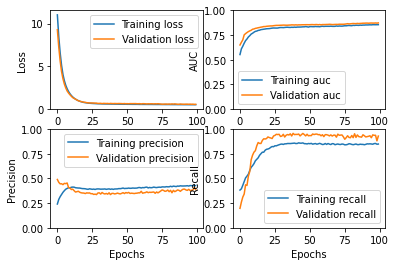

In [ ]:
# ===== Visualizations =====
score = model.evaluate(data_test)
print("Test AUC:", score[2])
print("Test Recall:", score[4])
history_dict = hist.history

max_v = 0
for v in history_dict["auc"]:
  if v > max_v:
    max_v = v

print("Max AUC (training): ", max_v)


plt.subplot(2, 2, 1)
plt.plot(history_dict["loss"], label = "Training loss")
plt.plot(history_dict["val_loss"], label = "Validation loss")
plt.ylabel("Loss")
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(history_dict["auc"], label = "Training auc")
plt.plot(history_dict["val_auc"], label = "Validation auc")
plt.ylabel("AUC")
plt.ylim(0, 1)
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(history_dict["precision"], label = "Training precision")
plt.plot(history_dict["val_precision"], label = "Validation precision")
plt.xlabel("Epochs")
plt.ylabel("Precision")
plt.ylim(0, 1)
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(history_dict["recall"], label = "Training recall")
plt.plot(history_dict["val_recall"], label = "Validation recall")
plt.xlabel("Epochs")
plt.ylabel("Recall")
plt.ylim(0, 1)
plt.legend()